In [324]:
import xarray as xr
import xroms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import time
import glob
start_time = time.time()
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [325]:
!pwd

/home/incois/prasanna/xROMS_post_process


# Define Depth levels

In [326]:
depth =  [
    0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -60,
    -70, -80, -90, -100, -120, -140, -160, -180, -200, -230, -260, -290,
    -330, -370, -410, -450, -500, -600, -725,
    -850, -1000, -1250, -1500, -1750, -2000, -2500,
    -3000, -3500, -4000]
print(depth)


[0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -60, -70, -80, -90, -100, -120, -140, -160, -180, -200, -230, -260, -290, -330, -370, -410, -450, -500, -600, -725, -850, -1000, -1250, -1500, -1750, -2000, -2500, -3000, -3500, -4000]


In [327]:
flist = sorted(glob.glob("/home/incois/prasanna/xROMS_post_process/roms_avg.nc"))

ds = xr.open_mfdataset(flist,decode_times=False ).squeeze().compute() 
print(ds.dims)
 
ds

FrozenMappingWarningOnValuesAccess({'tracer': 2, 's_rho': 40, 's_w': 41, 'eta_rho': 59, 'xi_rho': 86, 'eta_u': 59, 'xi_u': 85, 'eta_v': 58, 'xi_v': 86, 'eta_psi': 58, 'xi_psi': 85, 'ocean_time': 3})


<xarray.Dataset> Size: 10MB
Dimensions:        (tracer: 2, s_rho: 40, s_w: 41, eta_rho: 59, xi_rho: 86,
                    eta_u: 59, xi_u: 85, eta_v: 58, xi_v: 86, eta_psi: 58,
                    xi_psi: 85, ocean_time: 3)
Coordinates:
  * s_rho          (s_rho) float64 320B -0.9875 -0.9625 ... -0.0375 -0.0125
  * s_w            (s_w) float64 328B -1.0 -0.975 -0.95 ... -0.05 -0.025 0.0
    lon_rho        (eta_rho, xi_rho) float64 41kB 32.26 33.26 ... 116.3 117.3
    lat_rho        (eta_rho, xi_rho) float64 41kB -27.44 -27.44 ... 28.23 28.23
    lon_u          (eta_u, xi_u) float64 40kB 32.76 33.76 34.76 ... 115.8 116.8
    lat_u          (eta_u, xi_u) float64 40kB -27.44 -27.44 ... 28.23 28.23
    lon_v          (eta_v, xi_v) float64 40kB 32.26 33.26 34.26 ... 116.3 117.3
    lat_v          (eta_v, xi_v) float64 40kB -27.0 -27.0 -27.0 ... 27.78 27.78
    lon_psi        (eta_psi, xi_psi) float64 39kB 32.76 33.76 ... 115.8 116.8
    lat_psi        (eta_psi, xi_psi) float64 39kB -27.0 -27.0 ... 27.78 27.78
  * ocean_time     (ocean_time) float64 24B 6.092e+09 6.094e+09 6.095e+09
Dimensions without coordinates: tracer, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi
Data variables: (12/68)
    ntimes         int32 4B 600000
    ndtfast        int32 4B 20
    dt             float64 8B 3.6e+03
    dtfast         float64 8B 180.0
    dstart         float64 8B 0.0
    nHIS           int32 4B 0
    ...             ...
    mask_psi       (eta_psi, xi_psi) float64 39kB 0.0 2.0 1.0 ... 0.0 0.0 0.0
    zeta           (ocean_time, eta_rho, xi_rho) float32 61kB nan nan ... nan
    u              (ocean_time, s_rho, eta_u, xi_u) float32 2MB nan nan ... nan
    v              (ocean_time, s_rho, eta_v, xi_v) float32 2MB nan nan ... nan
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 2MB nan ... nan
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 2MB nan ... nan
Attributes: (12/29)
    file:              roms_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS nonlinear model averages file
    title:             IO 1 Deg, flow across u-face grid cell
    var_info:          varinfo.yaml
    ...                ...
    compiler_command:  /usr/bin/mpif90
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch        -O3 -...
    tiling:            1x1
    history:           ROMS, Version 4.3, Monday - October 27, 2025 -  2:41:4...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sm...
    CPP_options:       io_1deg, ANA_BSFLUX, ANA_BTFLUX, ANA_SMFLUX, ANA_SSFLU...

In [328]:
ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True, include_Z0=True)
ds.xroms.set_grid(xgrid)


var = ds['salt'] #ds[['temp']]


LON_RHO, LAT_RHO =  np.array(ds.lon_rho[0]), np.array(ds.lat_rho[:,0]) 

rr=xroms.interpll(var, LON_RHO, LAT_RHO, which='grid')
rr=rr.compute()

sliced_all = xroms.interp.isoslice(rr, np.array(depth) if depth[0]!=0 else np.array([-2,*depth[1:]]), xgrid, axis='Z')


end_time = time.time()

In [329]:
sliced_all['z_rho'] = -np.array(depth)

In [330]:
sliced_all = sliced_all.rename({'z_rho':'depth'})

(4000.0, 0.0)

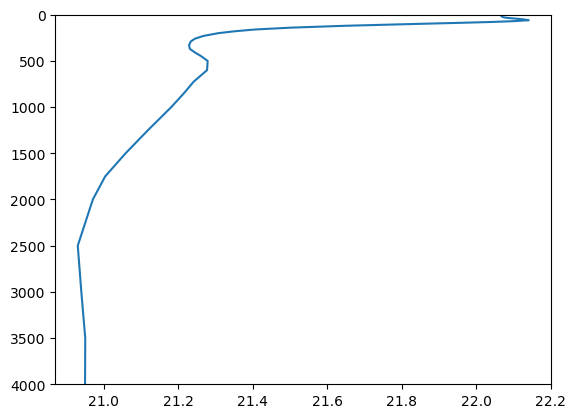

In [333]:
plt.plot(sliced_all.sel(lon=65,lat=10,method='nearest')[0],sliced_all['depth'])

plt.ylim([4000,0])

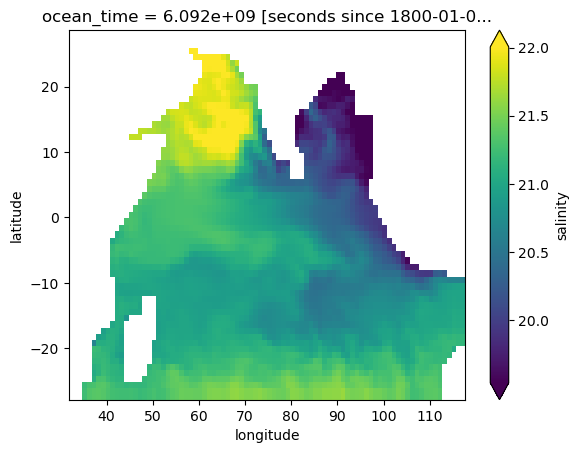

In [334]:
sliced_all[0,0].plot(robust=True)

# For U, V 

In [336]:
ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True, include_Z0=True)
ds.xroms.set_grid(xgrid)

var = ds['v'] #ds[['temp','salt','ALK','TIC','CHLA']]

LON_RHO, LAT_RHO =  np.array(ds.lon_v[0]), np.array(ds.lat_v[:,0]) #data.xt_ocean,data.yt_ocean#  np.array(var.lon_rho[0])  ,kk[0]

rr=xroms.interpll(var, LON_RHO, LAT_RHO, which='grid')
rr=rr.compute()

sliced_all = xroms.interp.isoslice(rr, np.array(depth) if depth[0]!=0 else np.array([-2,*depth[1:]]), xgrid, axis='Z')

end_time = time.time()

In [337]:
sliced_all['z_rho_v'] = -np.array(depth)

(4000.0, 0.0)

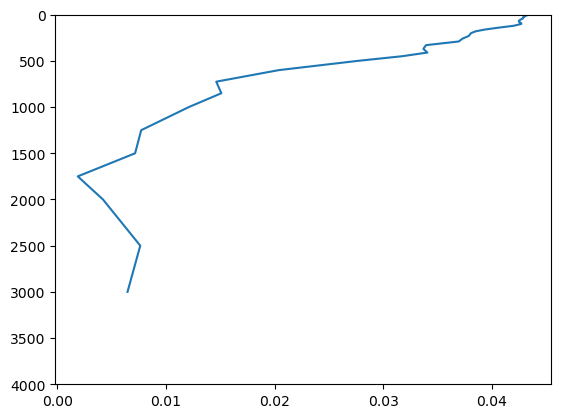

In [339]:
plt.plot(sliced_all.sel(lon=65,lat=-15,method='nearest')[0],sliced_all['z_rho_v'])

plt.ylim([4000,0])